## Import and Installation:

In [6]:
# pip install numpy pandas scikit-learn imbalanced-learn textstat nltk beautifulsoup4 vaderSentiment xgboost
# pip install pyenchant
# pip install langdetect
# pip install lime
# pip install textblob
# If you get an error with，please restart the kernal and run again

In [1]:
import os
import re
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import textstat
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
from textblob import TextBlob
from textstat import flesch_reading_ease

from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/zhangchengqi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


from pprint import pprint
%pprint

# Suppress warning messages
warnings.filterwarnings("ignore")

Pretty printing has been turned OFF


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/zhangchengqi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/zhangchengqi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhangchengqi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading Data:

Reading the 00combined_data.txt, and extract relevent fileds:
title, review_text, helpful, rating

In [4]:
# Read and parse the data
with open('00combined_data.txt', 'r') as file:
    data = file.read()

soup = BeautifulSoup(data, 'lxml')

# Extract reviews data
reviews = []
for review in soup.find_all('review'):
    review_data = {
        'title': review.title.string,
        'review_text': review.review_text.string,
        'helpful': review.helpful.string,
        'rating': review.rating.string  # Extract the 'rating' field
    }
    reviews.append(review_data)


## Features Extraction:

### Normalize Helpfulness Rating:

In [5]:
# Normalize the helpfulness rating
for review in reviews:
    helpful_text = str(review['helpful']).strip()
    if ' of ' in helpful_text:
        numerator, denominator = map(int, helpful_text.split(' of '))
        if denominator == 0:
            review['helpful'] = np.nan  # Denominator 0, set to NaN
        elif numerator == 0:
            review['helpful'] = 0  # No votes, set to 0
        else:
            ratio = numerator / denominator
            if ratio <= 0.5:
                review['helpful'] = 0  # Class 0
            else:
                review['helpful'] = 1  # Class 1
    else:
        review['helpful'] = np.nan  # Missing helpfulness score

In [5]:
pprint(reviews[:5])

[{'helpful': 0,
  'rating': '\n1.0\n',
  'review_text': '\n'
                 'THis book was horrible.  If it was possible to rate it lower '
                 'than one star i would have.  I am an avid reader and picked '
                 'this book up after my mom had gotten it from a friend.  I '
                 'read half of it, suffering from a headache the entire time, '
                 'and then got to the part about the relationship the 13 year '
                 'old boy had with a 33 year old man and i lit this book on '
                 "fire.  One less copy in the world...don't waste your money.\n"
                 '\n'
                 'I wish i had the time spent reading this book back so i '
                 'could use it for better purposes.  THis book wasted my '
                 'life\n',
  'title': '\nHorrible book, horrible.\n'},
 {'helpful': 0,
  'rating': '\n1.0\n',
  'review_text': '\n'
                 'I like to use the Amazon reviews when purchasing books, '


### Preprocessing Raw Data to Dataframe: 

In [6]:
# Create a DataFrame for the reviews
raw_df = pd.DataFrame(reviews)
print("The number of raw reviews:", len(raw_df))

The number of raw reviews: 8000


Convert to numerical, and removing reviews with no votes

In [7]:


# Remove reviews with no votes
df = raw_df[raw_df['helpful'].notnull()]

# Convert 'helpful' column to integers
df['helpful'] = df['helpful'].astype(int)

# Remove '\n' in the 'rating' column and convert to integers
df['rating'] = df['rating'].str.replace('\n', '').astype(float)

# Remove '\n' in the 'title' and 'review_text' columns
df['title'] = df['title'].apply(lambda x: re.sub(r'\n', ' ', x))
df['review_text'] = df['review_text'].apply(lambda x: re.sub(r'\n', ' ', x))

df



,title,review_text,helpful,rating
0,"Horrible book, horrible.",THis book was horrible. If it was possible t...,0,1.0
1,shallow self-indulgence,I like to use the Amazon reviews when purchas...,0,1.0
2,"Horrible book, horrible.",THis book was horrible. If it was possible t...,0,1.0
3,Disappointment,"I'm not sure who's writing these reviews, but...",1,1.0
4,A Disappointing Mess,I picked up the first book in this series (Th...,1,2.0
...,...,...,...,...
7995,Great filter-- noticably reduces dust.,"Even on its highest setting, it isn't very lo...",1,5.0
7996,Quite pleased.,I love this mug. Pros: -The 20 oz. size m...,1,5.0
7997,Does the job,"A fork is a fork, right? This does what you'...",1,5.0
7998,Pleased!,I have been looking high and low for a new fl...,0,4.0


### Inspection: Number of Voted vs Non-voted Reviews:

In [9]:
print("The number of voted reviews:", len(df))

The number of voted reviews: 6701


In [8]:
print("Non-voted reviews:", len(raw_df) - len(df))

Non-voted reviews: 1299


### Extract Stylometric Features for Title and Body before Pre-processing:

**List of Stylometric Features:**

sentence_length

word_count

sentence_length_average

punctuation_count

emotive_language_count

capitalization_count

word_variety

numerical_data_presence

In [9]:
sia = SentimentIntensityAnalyzer()

# Function to count emotive words
def count_emotive_words(text):
    words = word_tokenize(text)
    emotive_words = [word for word in words if sia.polarity_scores(word)['compound'] != 0]
    return len(emotive_words)

In [10]:
# Feature extraction/calculation for title and review text
for text_type in ['title', 'review_text']:
    # 1 count number of sentences
    df[f'sentence_length_{text_type}'] = df[text_type].apply(lambda x: len(sent_tokenize(x)))
    # 2 count number of words
    df[f'word_count_{text_type}'] = df[text_type].apply(lambda x: len(word_tokenize(x)))
    # 3 average (ratio of) number of words to sentences
    df[f'sentence_length_average_{text_type}'] = df[f'word_count_{text_type}'] / df[f'sentence_length_{text_type}']
    # 4 count number of punctuation used
    df[f'punctuation_count_{text_type}'] = df[text_type].apply(lambda x: len(re.findall(r'[^\w\s]', x)))
    # 5 Count number of emotive word, whichs polarity is not equal to zero
    df[f'emotive_language_count_{text_type}'] = df[text_type].apply(count_emotive_words)
    # 6 count number of words with all capital letter
    df[f'capitalization_count_{text_type}'] = df[text_type].apply(lambda x: len(re.findall(r'[A-Z]', x)))
    # 7 ratio of unique words used
    df[f'word_variety_{text_type}'] = df[text_type].apply(lambda x: len(set(word_tokenize(x))) / len(word_tokenize(x)) if word_tokenize(x) else 0)
    # 8 check if there is numerical character
    df[f'numerical_data_presence_{text_type}'] = df[text_type].apply(lambda x: 1 if len(re.findall(r'\d+', x)) > 0 else 0)
    # 9 check readability scores 
    df[f'readability_{text_type}'] = df[text_type].apply(flesch_reading_ease)


df.head()


,title,review_text,helpful,rating,sentence_length_title,word_count_title,sentence_length_average_title,punctuation_count_title,emotive_language_count_title,capitalization_count_title,...,readability_title,sentence_length_review_text,word_count_review_text,sentence_length_average_review_text,punctuation_count_review_text,emotive_language_count_review_text,capitalization_count_review_text,word_variety_review_text,numerical_data_presence_review_text,readability_review_text
0,"Horrible book, horrible.",THis book was horrible. If it was possible t...,0,1.0,1,5,5.0,2,2,1,...,9.21,7,121,17.285714,12,10,9,0.669421,1,91.31
1,shallow self-indulgence,I like to use the Amazon reviews when purchas...,0,1.0,1,2,2.0,1,0,0,...,-49.00,4,111,27.750000,16,9,7,0.720721,0,46.81
2,"Horrible book, horrible.",THis book was horrible. If it was possible t...,0,1.0,1,5,5.0,2,2,1,...,9.21,7,121,17.285714,12,10,9,0.669421,1,91.31
3,Disappointment,"I'm not sure who's writing these reviews, but...",1,1.0,1,1,1.0,0,1,1,...,-132.59,9,108,12.000000,30,7,13,0.675926,0,77.13
4,A Disappointing Mess,I picked up the first book in this series (Th...,1,2.0,1,3,3.0,0,2,3,...,34.59,21,672,32.000000,98,44,61,0.477679,1,58.86


In [13]:
df.isnull().sum()

title                                  0
review_text                            0
helpful                                0
rating                                 0
sentence_length_title                  0
word_count_title                       0
sentence_length_average_title          0
punctuation_count_title                0
emotive_language_count_title           0
capitalization_count_title             0
word_variety_title                     0
numerical_data_presence_title          0
readability_title                      0
sentence_length_review_text            0
word_count_review_text                 0
sentence_length_average_review_text    0
punctuation_count_review_text          0
emotive_language_count_review_text     0
capitalization_count_review_text       0
word_variety_review_text               0
numerical_data_presence_review_text    0
readability_review_text                0
dtype: int64

### Text pre-processing:

In [11]:
# Define the stop words
stop_words = set(stopwords.words('english'))

# Preprocess the text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize the text into words
    words = word_tokenize(text)
    # Remove stop words
    words = [word for word in words if word not in stop_words]
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Remove words with fewer than 3 characters
    words = [word for word in words if len(word) >= 3]
    # Remove numbers
    words = [word for word in words if not word.isnumeric()]
    # Remove words with repeating characters
    words = [word for word in words if not re.match(r'(.)\1{2,}', word)]
    # Join the words back into a string
    processed_text = ' '.join(words)
    return processed_text

# Apply the preprocessing function to the 'title' and 'review_text' columns
df['title'] = df['title'].apply(preprocess_text)
df['review_text'] = df['review_text'].apply(preprocess_text)

In [12]:
df.isnull().sum()

title                                  0
review_text                            0
helpful                                0
rating                                 0
sentence_length_title                  0
word_count_title                       0
sentence_length_average_title          0
punctuation_count_title                0
emotive_language_count_title           0
capitalization_count_title             0
word_variety_title                     0
numerical_data_presence_title          0
readability_title                      0
sentence_length_review_text            0
word_count_review_text                 0
sentence_length_average_review_text    0
punctuation_count_review_text          0
emotive_language_count_review_text     0
capitalization_count_review_text       0
word_variety_review_text               0
numerical_data_presence_review_text    0
readability_review_text                0
dtype: int64

### Performing POS tagging, n-grams, sentiment analysis and subjectivity analysis:

In [13]:
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk import word_tokenize, pos_tag
import nltk
import pandas as pd
import numpy as np
from collections import Counter

nltk.download('averaged_perceptron_tagger')

# Function to get POS tagging counts
def get_pos_tags(text):
    tags = [tag for word, tag in nltk.pos_tag(word_tokenize(text)) if tag in ['NN', 'VB', 'JJ']]
    return dict(Counter(tags))

# Function to get sentiment
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Function to get subjectivity
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Drop rows where 'title' or 'review_text' is NaN
df = df.dropna(subset=['title', 'review_text'])

for text_type in ['title', 'review_text']:
    # Calculate POS tags, sentiment score, and subjectivity score
    df[f'pos_tags_{text_type}'] = df[text_type].apply(get_pos_tags)

    pos_df = df[f'pos_tags_{text_type}'].apply(pd.Series)
    pos_df.columns = [f'{col}_{text_type}' for col in pos_df.columns]  # Modified here for desired column names

    df = df.join(pos_df)
    df.drop(columns=[f'pos_tags_{text_type}'], inplace=True)

    df[f'sentiment_{text_type}'] = df[text_type].apply(get_sentiment)
    df[f'subjectivity_{text_type}'] = df[text_type].apply(get_subjectivity)

    # Count the number of 2-grams in each document
    count_vectorizer = CountVectorizer(ngram_range=(2, 2))
    count_matrix = count_vectorizer.fit_transform(df[text_type])
    df[f'2gram_count_{text_type}'] = np.sum(count_matrix.toarray(), axis=1)
    
    # Fill NaN values in the POS columns with 0
    df[[f'NN_{text_type}', f'VB_{text_type}', f'JJ_{text_type}']] = df[[f'NN_{text_type}', f'VB_{text_type}', f'JJ_{text_type}']].fillna(0)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/zhangchengqi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [14]:
df.head()

,title,review_text,helpful,rating,sentence_length_title,word_count_title,sentence_length_average_title,punctuation_count_title,emotive_language_count_title,capitalization_count_title,...,VB_title,sentiment_title,subjectivity_title,2gram_count_title,NN_review_text,JJ_review_text,VB_review_text,sentiment_review_text,subjectivity_review_text,2gram_count_review_text
0,horrible book horrible,book horrible possible rate lower one star wou...,0,1.0,1,5,5.0,2,2,1,...,0.0,-1.000000,1.0000,2,27.0,8.0,2.0,-0.059722,0.399306,50
1,shallow selfindulgence,like use amazon review purchasing book especia...,0,1.0,1,2,2.0,1,0,0,...,0.0,-0.333333,0.5000,1,25.0,6.0,0.0,-0.211806,0.686111,50
2,horrible book horrible,book horrible possible rate lower one star wou...,0,1.0,1,5,5.0,2,2,1,...,0.0,-1.000000,1.0000,2,27.0,8.0,2.0,-0.059722,0.399306,50
3,disappointment,sure who writing review read repitition repiti...,1,1.0,1,1,1.0,0,1,1,...,0.0,-0.600000,0.4000,0,20.0,10.0,1.0,-0.086042,0.565437,43
4,disappointing mess,picked first book series eyre affair based pur...,1,2.0,1,3,3.0,0,2,3,...,0.0,-0.387500,0.4375,1,130.0,69.0,4.0,0.059187,0.466751,302


In [15]:
df.isnull().sum()

title                                  0
review_text                            0
helpful                                0
rating                                 0
sentence_length_title                  0
word_count_title                       0
sentence_length_average_title          0
punctuation_count_title                0
emotive_language_count_title           0
capitalization_count_title             0
word_variety_title                     0
numerical_data_presence_title          0
readability_title                      0
sentence_length_review_text            0
word_count_review_text                 0
sentence_length_average_review_text    0
punctuation_count_review_text          0
emotive_language_count_review_text     0
capitalization_count_review_text       0
word_variety_review_text               0
numerical_data_presence_review_text    0
readability_review_text                0
JJ_title                               0
NN_title                               0
VB_title        

In [16]:
# Export the DataFrame to an Excel file
df.to_excel('features.xlsx', index=False)

### Check Class Dristribution:

In [17]:
# Find columns with all zero values
zero_columns = df.columns[(df == 0).all()]

# Print the columns with all zero values
print(zero_columns)

# Drop columns with all zero values
df = df.drop(zero_columns, axis=1)

# Print the columns with all zero values
print(zero_columns)

Index([], dtype='object')
Index([], dtype='object')


In [18]:
class_distribution = df['helpful'].value_counts()
print(class_distribution)


helpful
1    4497
0    2204
Name: count, dtype: int64


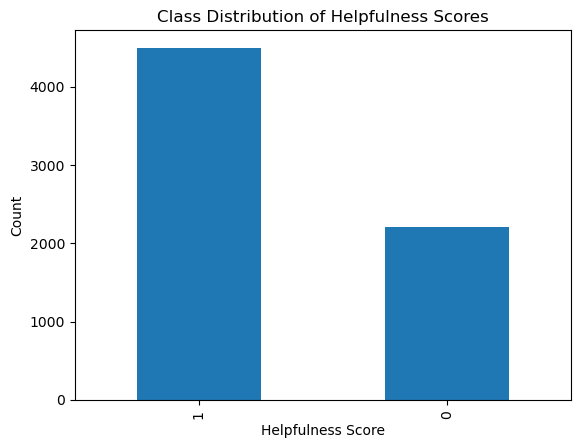

In [19]:
class_distribution.plot(kind='bar')
plt.xlabel('Helpfulness Score')
plt.ylabel('Count')
plt.title('Class Distribution of Helpfulness Scores')
plt.show()
